In [1]:
# some always important inputs
import sys
import os
import random
import time
import numpy as np
import cPickle
#import PIL
from corebio.seq import Alphabet
from weblogolib import LogoData, LogoFormat, LogoOptions, classic, png_print_formatter, png_formatter
from cStringIO import StringIO
np.set_printoptions(precision=2, suppress=True)

# the underlying convRBM implementation
sys.path.append(os.path.abspath('../code'))
from convRBM import CRBM
import getData as dataRead

# plotting and data handling
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split

# the biopython stuff
import Bio.SeqIO as sio
import Bio.motifs.matrix as mat
from Bio.Alphabet import IUPAC
from Bio.Seq import Seq
from Bio import motifs as mot

ERROR (theano.sandbox.cuda): Failed to compile cuda_ndarray.cu: libcublas.so.7.0: cannot open shared object file: No such file or directory
ERROR:theano.sandbox.cuda:Failed to compile cuda_ndarray.cu: libcublas.so.7.0: cannot open shared object file: No such file or directory
WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu is not available  (error: cuda unavailable)


Couldn't import dot_parser, loading of dot files will not be possible.


In [111]:
# read in the data
seqReader = seqReader = dataRead.SeqReader()
data_sc = np.array([i for i in seqReader.readSequencesFromFile('../data/stemcells.fa')])
data_fib = np.array([i for i in seqReader.readSequencesFromFile('../data/fibroblast.fa')])

print data_sc.shape
print data_fib.shape

skip sequence containing N
(3997, 1, 4, 200)
(40786, 1, 4, 200)


In [33]:
fib2 = seqReader.readSequencesFromFile('../data/fibroblast.fa')
fib2_per = np.random.permutation(len(fib2))
data_fib = np.array([fib2[i] for i in fib2_per[:4000]])

skip sequence containing N


In [54]:
# read in the models
date_string_1 = 'Training_stemcells_sparsity_1'
modelDir_1 = '../../training/' + date_string_1
stemcell_model = CRBM(file_name = modelDir_1 + '/model.pkl')

date_string_2 = 'Training_fibroblast_sparsity_1'
modelDir_2 = '../../training/' + date_string_2
fibroblast_model = CRBM(file_name = modelDir_2 + '/model.pkl')

In [55]:
print stemcell_model.motifs.get_value()[0]
print fibroblast_model.motifs.get_value()[0]

[[[ 0.69 -0.51  1.21  1.35  0.76  0.09  0.09 -1.73  0.31]
  [ 0.23 -0.8   0.44  0.36  1.34 -0.09 -1.84  1.47  0.64]
  [ 1.34  0.14 -0.05  1.54  0.85 -2.03  1.76  1.61  0.54]
  [-0.61 -0.73 -0.29  0.03 -1.31  0.49  0.84 -0.98  0.94]]]
[[[ 0.16 -0.22  0.36  0.21 -0.99 -1.08 -0.84 -0.24 -1.87]
  [ 0.04 -0.21 -0.47 -0.69  0.15 -1.33 -0.93  0.16 -0.34]
  [-1.13  1.95 -1.07  0.37  0.36  0.32  0.44 -1.16  0.01]
  [-0.91  0.84  0.2   0.53  0.14 -0.55 -0.32 -1.67  0.06]]]


In [56]:
print "Model for stemcell data"
print "=============================="
stemcell_model.printHyperParams()
print "Model for fibroblast data"
print "=============================="
fibroblast_model.printHyperParams()

Model for stemcell data
{'batch_size': 20,
 'cd_k': 5,
 'cd_method': 'pcd',
 'doublestranded': False,
 'epochs': 300,
 'learning_rate': 0.5,
 'momentum': 0.9,
 'motif_length': 9,
 'number_of_motifs': 100,
 'pooling_factor': 4,
 'rho': 0.0011111111111111111,
 'sparsity': 1,
 'verbose': False}
Model for fibroblast data
{'batch_size': 20,
 'cd_k': 5,
 'cd_method': 'pcd',
 'doublestranded': False,
 'epochs': 300,
 'learning_rate': 0.5,
 'momentum': 0.9,
 'motif_length': 9,
 'number_of_motifs': 100,
 'pooling_factor': 4,
 'rho': 0.0011111111111111111,
 'sparsity': 1,
 'verbose': False}


In [57]:
import theano
import theano.tensor as T
batchSize = 100

def getFreeEnergyFunction (model, data):
    D = T.tensor4('data')
    dataS = theano.shared(value=data, borrow=True, name='givenData')
    index = T.lscalar()
    energy = model.freeEnergyForData(D)
    return theano.function([index], energy, allow_input_downcast=True,
                           givens={D: dataS[index*batchSize:(index+1)*batchSize]},
                           name='freeDataEnergy'
                          )

def applyFreeEnergyFunction(model, data):
    fun = getFreeEnergyFunction(model, data)
    iterations = data.shape[0] / batchSize
    score = 0.
    for batchIdx in xrange(iterations):
        score += fun(batchIdx).sum()
    score /= iterations
    return score

def getFreeEnergyPoints(model, data):
    fun = getFreeEnergyFunction(model, data)
    iterations = data.shape[0] / batchSize
    M = np.zeros(data.shape[0])
    for batchIdx in xrange(iterations):
        #print "Setting from idx " + str(batchIdx*batchSize) + " to " + str((batchIdx+1)*batchSize)
        M[batchIdx*batchSize:(batchIdx+1)*batchSize] = fun(batchIdx)
    M[(batchIdx+1)*batchSize:] = fun(batchIdx+1)
    return M

In [58]:
print "Mean Free Energy for Model 1 (dataset 1 and 2)"
print applyFreeEnergyFunction(stemcell_model, data_sc)
print applyFreeEnergyFunction(stemcell_model, data_fib)
print "Mean Free Energy for Model 2 (dataset 1 and 2)"
print applyFreeEnergyFunction(fibroblast_model, data_sc)
print applyFreeEnergyFunction(fibroblast_model, data_fib)

Mean Free Energy for Model 1 (dataset 1 and 2)
-44.3907337219
-40.426161164
Mean Free Energy for Model 2 (dataset 1 and 2)
-30.8322683103
-34.322867699


In [59]:
P11 = getFreeEnergyPoints(stemcell_model, data_sc)
print "ESC data on ESC model done"
P12 = getFreeEnergyPoints(stemcell_model, data_fib)
print "IMR90 data on ESC model done"
P21 = getFreeEnergyPoints(fibroblast_model, data_sc)
print "ESC data on IMR90 model done"
P22 = getFreeEnergyPoints(fibroblast_model, data_fib)
print "IMR90 data on IMR90 model done"

ESC data on ESC model done
IMR90 data on ESC model done
ESC data on IMR90 model done
IMR90 data on IMR90 model done


In [60]:
print P11.shape
print P12.shape

(3997,)
(4000,)


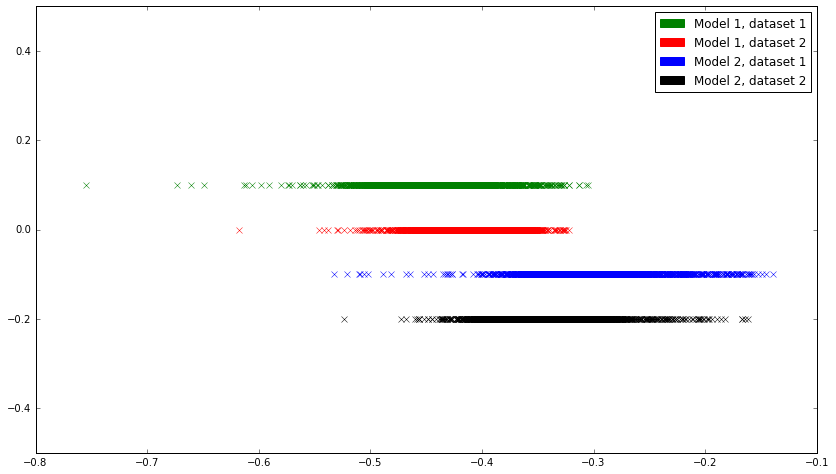

In [61]:
%matplotlib inline
import matplotlib.patches as mpatches
fig = plt.figure(figsize=(14,8))
plt.plot(P11, np.zeros_like(P11)+0.1, 'x', color='green')
plt.plot(P12, np.zeros_like(P12), 'x', color='red')
plt.plot(P21, np.zeros_like(P21)-0.1, 'x', color='blue')
plt.plot(P22, np.zeros_like(P22)-0.2, 'x', color='black')
plt.ylim((-.5, .5))
green_patch = mpatches.Patch(color='green', label='Model 1, dataset 1')
red_patch = mpatches.Patch(color='red', label='Model 1, dataset 2')
blue_patch = mpatches.Patch(color='blue', label='Model 2, dataset 1')
black_patch = mpatches.Patch(color='black', label='Model 2, dataset 2')
plt.legend(handles=[green_patch, red_patch, blue_patch, black_patch])
plt.show()
fig.savefig('discriminative_power.png', dpi=400)

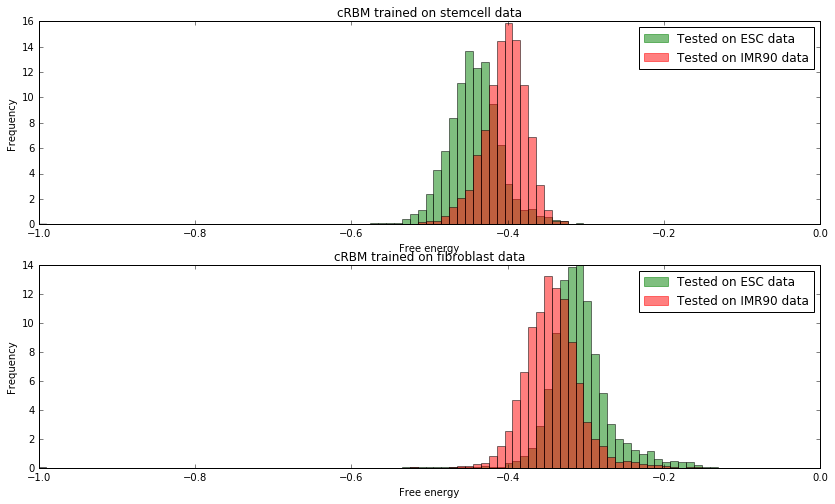

In [62]:
%matplotlib inline
import matplotlib.patches as mpatches

bins = np.linspace(-1, 0, 100)
fig = plt.figure(figsize=(14,8))
plt.subplot(2,1,1)
plt.hist(P11, bins, color='green', normed=True, alpha=0.5)
plt.hist(P12, bins, color='red', normed=True, alpha=0.5)
plt.title('cRBM trained on stemcell data')
plt.ylabel('Frequency')
plt.xlabel('Free energy')
plt.xlim((-1, 0))
green_patch = mpatches.Patch(color='green', label='Tested on ESC data', alpha=0.5)
red_patch = mpatches.Patch(color='red', label='Tested on IMR90 data', alpha=0.5)
plt.legend(handles=[green_patch, red_patch])

plt.subplot(2,1,2)
plt.hist(P21, bins, color='green', normed=True, alpha=0.5)
plt.hist(P22, bins, color='red', normed=True, alpha=0.5)
plt.title('cRBM trained on fibroblast data')
plt.ylabel('Frequency')
plt.xlabel('Free energy')
plt.xlim((-1,0))
green_patch = mpatches.Patch(color='green', label='Tested on ESC data', alpha=0.5)
red_patch = mpatches.Patch(color='red', label='Tested on IMR90 data', alpha=0.5)
plt.legend(handles=[green_patch, red_patch])
fig.savefig(modelDir_1 + '/discriminative_histograms.png', dpi=400)
fig.savefig(modelDir_2 + '/discriminative_histograms.png', dpi=400)

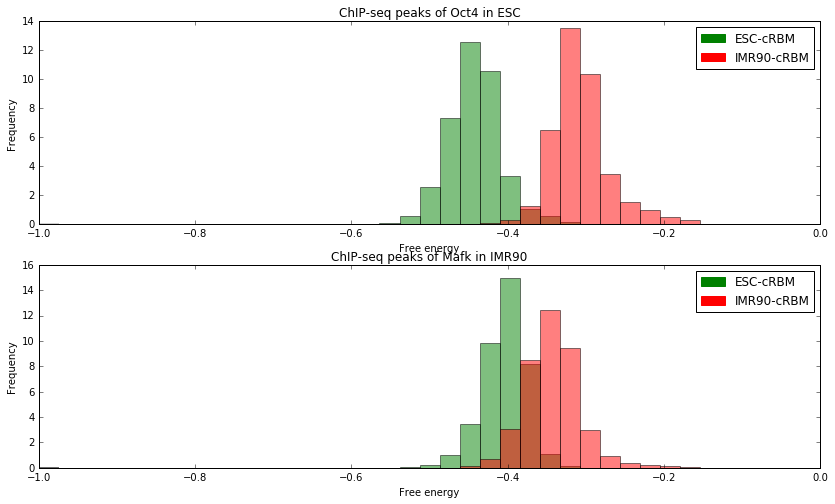

In [63]:
%matplotlib inline

bins = np.linspace(-1, 0, 40)
fig = plt.figure(figsize=(14,8))
plt.subplot(2,1,1)
plt.hist(P11, bins, color='green', normed=True, alpha=0.5)
plt.hist(P21, bins, color='red', normed=True, alpha=0.5)
plt.title('ChIP-seq peaks of Oct4 in ESC')
plt.ylabel('Frequency')
plt.xlabel('Free energy')
plt.xlim((-1,0))
green_patch2 = mpatches.Patch(color='green', label='ESC-cRBM')
red_patch2 = mpatches.Patch(color='red', label='IMR90-cRBM')
plt.legend(handles=[green_patch2, red_patch2])

plt.subplot(2,1,2)
plt.hist(P12, bins, color='green', normed=True, alpha=0.5)
plt.hist(P22, bins, color='red', normed=True, alpha=0.5)
plt.title('ChIP-seq peaks of Mafk in IMR90')
plt.ylabel('Frequency')
plt.xlabel('Free energy')
plt.xlim((-1,0))
green_patch = mpatches.Patch(color='green', label='ESC-cRBM')
red_patch = mpatches.Patch(color='red', label='IMR90-cRBM')
plt.legend(handles=[green_patch, red_patch])
fig.savefig(modelDir_1 + '/discriminative_histograms.png', dpi=400)
fig.savefig(modelDir_2 + '/discriminative_histograms.png', dpi=400)

# Calculating area under the curve and respective ROC plots
We want to find out how well we are predicting, using the standard measures of machine learning.
Thus, we want to calculate the accuracy and ROC curve as well as the AUC (area under the curve) value.

Done reading models...
[ 0.26  0.13  0.13  0.1   0.1   0.09  0.09  0.09  0.09  0.08  0.08  0.08
  0.08  0.08  0.08  0.08  0.08  0.08  0.08  0.08  0.08  0.07  0.07  0.07
  0.07  0.07  0.07  0.07  0.07  0.07  0.07  0.07  0.07  0.07  0.07  0.07
  0.07  0.07  0.07  0.07  0.07  0.07  0.07  0.07  0.07  0.06  0.06  0.06
  0.06  0.06  0.06  0.06  0.06  0.06  0.06  0.06  0.06  0.06  0.06  0.06
  0.06  0.06  0.06  0.06  0.06  0.06  0.06  0.06  0.06  0.06  0.06  0.06
  0.06  0.06  0.06  0.06  0.06  0.06  0.06  0.06  0.06  0.06  0.06  0.06
  0.06  0.06  0.06  0.06  0.06  0.06  0.06  0.06  0.06  0.06  0.06  0.06
  0.06  0.06  0.06  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05
  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05
  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05
  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05
  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05
  0.05  0.05  0.05  0.05  0.

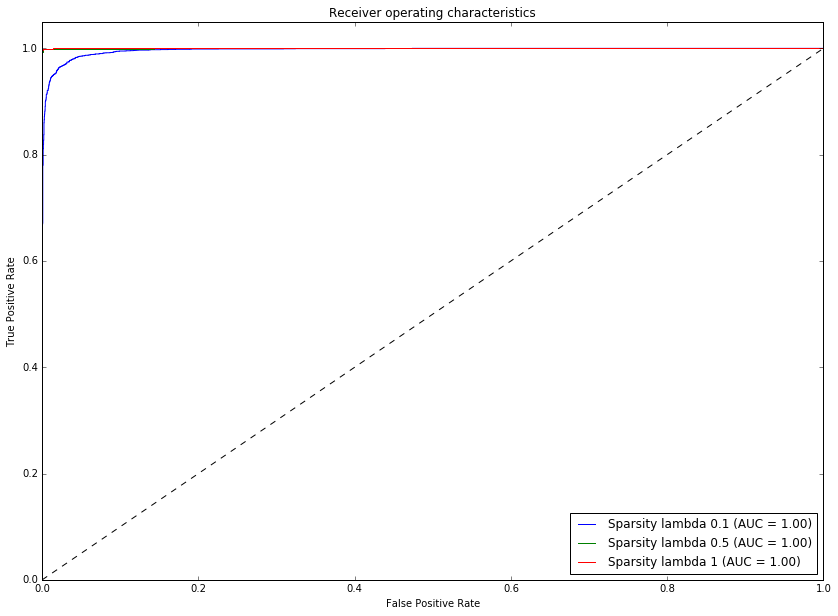

In [126]:
from sklearn.metrics import roc_curve, auc

models_sc = []
models_fib = []
dir_names = [('Training_stemcells_sparsity_0.1', 'Training_fibroblast_sparsity_0.1'),
             ('Training_stemcells_sparsity_0.5', 'Training_fibroblast_sparsity_0.5'),
             ('Training_stemcells_sparsity_1', 'Training_fibroblast_sparsity_1')]

for dir_name1, dir_name2 in dir_names:
    # read in the models
    modelDir_1 = '../../training/' + dir_name1
    stemcell_model = CRBM(file_name = modelDir_1 + '/model.pkl')

    modelDir_2 = '../../training/' + dir_name2
    fibroblast_model = CRBM(file_name = modelDir_2 + '/model.pkl')
    
    models_sc.append(stemcell_model)
    models_fib.append(fibroblast_model)

print "Done reading models..."
plt.figure(figsize=(14,10))

for i in range(len(models_sc)):
    # calculate free energy for all data
    P11 = getFreeEnergyPoints(models_sc[i], data_sc)
    P12 = getFreeEnergyPoints(models_sc[i], data_fib)
    P21 = getFreeEnergyPoints(models_fib[i], data_sc)
    P22 = getFreeEnergyPoints(models_fib[i], data_fib)

    # get the scores and plot them
    y_true = np.concatenate( (np.ones(P11.shape[0]), np.zeros(P22.shape[0])), axis=0 )
    y_score = np.concatenate( (-P11 + P21, -P22 + P12), axis=0 )
    fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=y_score)
    print thresholds
    roc_auc = auc(fpr, tpr)
    assert models_sc[i].hyper_params['sparsity'] == models_fib[i].hyper_params['sparsity']
    sparsity = models_sc[i].hyper_params['sparsity']
    plt.plot(fpr, tpr, label='Sparsity lambda ' + str(sparsity) + ' (AUC = %0.2f)' % roc_auc)
    
    print "Done with sparsity constraint " + str(sparsity)

plt.plot([0, 1], [0, 1], 'k--') # the diagonal
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics')
plt.legend(loc="lower right")
plt.show()
plt.savefig('ROC_for_sparsity.png', dpi=400)

In [124]:
print fpr
print tpr
print thresholds

[ 0.    0.05  1.  ]
[ 0.  1.  1.]
[2 1 0]


In [80]:
print P11.shape
print P12.shape
print P21.shape
print P22.shape

(3997,)
(4000,)
(3997,)
(4000,)


In [83]:
print y_true.sum()

3997.0
